In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import torch
import math
import os
import datetime
import pickle
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
def MAE(pred, true):
    return np.mean(np.abs(pred - true))

def MSE(pred, true):
    return np.mean((pred - true) ** 2)

def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))

def DA(pred, true):
    da = (pred[1:] - true[:-1]) * (true[1:] - pred[:-1]) > 0
    return da.mean()

def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    da = DA(pred, true)
    
    return mae, mse, rmse, mape, mspe, da

In [3]:
data_path=r'datasets/gefcom2017.csv'

df = pd.read_csv(data_path, encoding='gb18030')
# df['trend'] = range(1,len(df)+1)
# df = df[['trend','ts', 'zone', 'demand', 'drybulb', 'dewpnt', ]]
df = df[['ts', 'trend', 'zone', 'demand', 'drybulb', 'dewpnt' ]]
df['ts'] = pd.to_datetime(df['ts'])


df['drybulb^2'] = df['drybulb'].apply(lambda x: x**2)
df['drybulb^3'] = df['drybulb'].apply(lambda x: x**3)


# 由露点温度和干球温度转换成摄氏温度后，计算相对湿度
df['RH'] = 100 * ( ((17.27 * ((df['dewpnt'] - 32 )/1.8) ) / (
    ((df['dewpnt'] - 32 )/1.8) + 237.3)).apply(math.exp) / (
    (17.27 * ((df['drybulb'] - 32 )/1.8) ) / (
         ((df['drybulb'] - 32 )/1.8) + 237.3)).apply(math.exp) )
df['RH^2'] = df['RH'].apply(lambda x: x**2)
df['RH^3'] = df['RH'].apply(lambda x: x**3)
df = df.drop(columns=['dewpnt'])


df['month'] = df['ts'].apply(lambda x: x.month - 1)
df['week'] = df['ts'].apply(lambda x: x.weekday())
df['hour'] = df['ts'].apply(lambda x: x.hour)

start = pd.Timestamp(2008, 1, 1)
end = pd.Timestamp(2017, 1, 1)
df = df.loc[df['ts'].apply(lambda x: start<= x < end )]

df['S'] = df['month'].apply(lambda x: 1 if x in [6,7,8,9] else 0)


data_path=r'datasets/ISONE2017-2024.csv'

df2 = pd.read_csv(data_path, encoding='gb18030')
df2['ts'] = df2['ts'].apply(lambda x: pd.Timestamp(x) )

# start = pd.Timestamp(2018, 1, 1)
# end = pd.Timestamp(2020, 1, 1)
# df2 = df2.loc[df2['ts'].apply(lambda x: start<= x < end )]

# 由露点温度和干球温度转换成摄氏温度后，计算相对湿度
df2['RH'] = 100 * ( ((17.27 * ((df2['dewpnt'] - 32 )/1.8) ) / (
    ((df2['dewpnt'] - 32 )/1.8) + 237.3)).apply(math.exp) / (
    (17.27 * ((df2['drybulb'] - 32 )/1.8) ) / (
         ((df2['drybulb'] - 32 )/1.8) + 237.3)).apply(math.exp) )

df2 = df2.drop(columns=['dewpnt'])

df2['drybulb^2'] = df2['drybulb'].apply(lambda x: x**2)
df2['drybulb^3'] = df2['drybulb'].apply(lambda x: x**3)

df2['RH^2'] = df2['RH'].apply(lambda x: x**2)
df2['RH^3'] = df2['RH'].apply(lambda x: x**3)

df2 = df2[['ts',  'zone', 'demand', 'drybulb', 'RH', 'drybulb^2', 'drybulb^3', 'RH^2', 'RH^3', 'month', 'week', 'hour']]

df2['S'] = df2['month'].apply(lambda x: 1 if x in [6,7,8,9] else 0)

In [12]:
def get_zone_train(df1, df2, zone, train_start, train_end, valid_start, valid_end, test_start, test_end, log=False, num_hour = 0, num_day = 0, num_hour_RH = 0, num_day_RH = 0, RH = False):
    if zone != 'MASS':
        df_ct1 = df1.groupby('zone').get_group(zone)
        df_ct2 = df2.groupby('zone').get_group(zone)
        df_ct = pd.concat([df_ct1, df_ct2])
    else:
        df_ct = df1.groupby('zone').get_group(zone)

    df_ct = df_ct.drop(columns=['zone'])
    df_ct = df_ct.loc[df_ct['ts'].apply(lambda x: train_start - datetime.timedelta(days=240) <= x < test_end )]
    
    df_ct['trend'] = range(1,len(df_ct)+1)
    df_ct = df_ct[['trend', 'ts' , 'demand', 'drybulb', 'RH', 'drybulb^2', 'drybulb^3', 'RH^2', 'RH^3', 'month', 'week', 'hour']]
    
    if RH != True:
        df_ct = df_ct.drop(columns=['RH', 'RH^2', 'RH^3'])

    df_ct = pd.get_dummies(df_ct, columns = ['month', 'hour', 'week'])
    
    for i in range(num_hour):
        df_ct['drybulb_lag{}'.format(i+1)] = df_ct['drybulb'].shift(axis=0, periods=i+1)
        df_ct['drybulb^2_lag{}'.format(i+1)] = df_ct['drybulb^2'].shift(axis=0, periods=i+1)
        df_ct['drybulb^3_lag{}'.format(i+1)] = df_ct['drybulb^3'].shift(axis=0, periods=i+1)

    for k in range(num_day):
        df_ct['drybulb^a_lag{}'.format(k)] = 0
        for j in range(24):
            df_ct['drybulb^a_lag{}'.format(k)] += df_ct['drybulb'].shift(axis=0, periods= 24 * k + j + 1)

        df_ct['drybulb^a_lag{}'.format(k)] /= 24

        df_ct['drybulb^a^2_lag{}'.format(k)] = df_ct['drybulb^a_lag{}'.format(k)].apply(lambda x: x**2)
        df_ct['drybulb^a^3_lag{}'.format(k)] = df_ct['drybulb^a_lag{}'.format(k)].apply(lambda x: x**3)

    if RH == True:
        for i in range(num_hour_RH):
            df_ct['RH_lag{}'.format(i+1)] = df_ct['RH'].shift(axis=0, periods=i+1)
            df_ct['RH^2_lag{}'.format(i+1)] = df_ct['RH^2'].shift(axis=0, periods=i+1)
            df_ct['RH^3_lag{}'.format(i+1)] = df_ct['RH^3'].shift(axis=0, periods=i+1)

        for k in range(num_day_RH):
            df_ct['RH^a_lag{}'.format(k)] = 0
            for j in range(24):
                df_ct['RH^a_lag{}'.format(k)] += df_ct['RH'].shift(axis=0, periods= 24 * k + j + 1)

            df_ct['RH^a_lag{}'.format(k)] /= 24

            df_ct['RH^a^2_lag{}'.format(k)] = df_ct['RH^a_lag{}'.format(k)].apply(lambda x: x**2)
            df_ct['RH^a^3_lag{}'.format(k)] = df_ct['RH^a_lag{}'.format(k)].apply(lambda x: x**3)
    
    train_data = df_ct.loc[df_ct['ts'].apply(lambda x: train_start <= x < train_end)]
    valid_data = df_ct.loc[df_ct['ts'].apply(lambda x: valid_start <= x < valid_end)]
    test_data = df_ct.loc[df_ct['ts'].apply(lambda x: test_start <= x < test_end)]
    
    if log:
        print("Total Set, (Nums, Variables):", df_ct.shape)
    
    X_train, y_train = train_data.drop(columns=['ts', 'demand']
                                      ).values.copy(), train_data['demand'].values.copy()
    X_valid, y_valid = valid_data.drop(columns=['ts', 'demand']
                                      ).values.copy(), valid_data['demand'].values.copy()
    X_test, y_test = test_data.drop(columns=['ts', 'demand']
                                   ).values.copy(), test_data['demand'].values.copy()
    if log:
        print("zone: {}, \n\t Train start: {}, \n\t Train end: {}".format(zone, train_start, train_end))
        print("zone: {}, \n\t Valid start: {}, \n\t Valid end: {}".format(zone, valid_start, valid_end))
        print("zone: {}, \n\t Test start: {}, \n\t Test end: {}".format(zone, test_start, test_end))
        print("Train set:", X_train.shape)
        print("Valid set:", X_valid.shape)
        print("Test set:", X_test.shape)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 1 Load Forecasting Curve

In [13]:
# Plotting is performed using the CT region from the first experiment.
i = 0
preMLP, preTFT, preLSTM, pre_our, preGBRT, preDL, preNB, preNL = [], [], [], [], [], [], [], []
zone_name = 'CT'
zone = 'zone_' + zone_name

# Try to read the pickle file.
with open(f"result_record_all/day/other model/oneday_benckmark_{i}.pkl", 'rb') as f:
    predict_benchmark = pickle.load(f)  # Load the file using pickle.

# print("The file has been successfully loaded.")

# Try to read the pickle file.
with open(f"result_record_all/day/GBTR/oneday_GBTR_{i}.pkl", 'rb') as f:
    predict_GBRT = pickle.load(f)  # Load the file using pickle.

# print("The file has been successfully loaded.")

# Try to read the pickle file.
with open(f"result_record_all/ROEHPE/our_recode{i}.pkl", 'rb') as f:
    predict_our = pickle.load(f)  # Load the file using pickle.

# Try to read the pickle file.
with open(f"result_record_all/Tao and RRH/Tao and RRH result.pkl", 'rb') as f:
    predict_RRHTao = pickle.load(f)  # Load the file using pickle.

# print("The file has been successfully loaded.")

print("The file has been successfully loaded.")


label_std = (predict_benchmark[zone]['train_std'][0]).numpy()
label_mean = (predict_benchmark[zone]['train_mean'][0]).numpy()

preNL = ( (predict_benchmark[zone]['Neural Laplace']['test_preds']) * label_std + label_mean )
preLSTM = ( (predict_benchmark[zone]['LSTM']['test_preds']) * label_std + label_mean )
preMLP = ( (predict_benchmark[zone]['MLP']['test_preds']) * label_std + label_mean )
preDL = ( (predict_benchmark[zone]['DLinear']['test_preds']) * label_std + label_mean )
preNB = ( (predict_benchmark[zone]['NBEATSx']['test_preds']) * label_std + label_mean )
preTFT = ( (predict_benchmark[zone]['TFT']['test_preds']) * label_std + label_mean )

preGBRT = ( (predict_GBRT[zone]['GBRT']['test_preds']) * label_std + label_mean )
pre_our = ( predict_our[zone]['pre_test_load'] )

prePers = (predict_benchmark[zone]['Persistence']['test_preds']) * label_std + label_mean 
preTao = predict_RRHTao[zone_name]['Tao']['test_preds']
preRRH = predict_RRHTao[zone_name]['RRH']['test_preds']

print("The file has been successfully loaded.")

np.array(pre_our).shape, np.array(preGBRT).shape

The file has been successfully loaded.
The file has been successfully loaded.


((8760,), (365, 24, 1))

In [14]:
# Generate hourly timestamps for the entire year of 2018.
start_date = '2018-01-01 00:00:00'
end_date = '2018-12-31 23:59:59'

hourly_timestamps = pd.date_range(start=start_date, end=end_date, freq='h')

print(hourly_timestamps[:5])

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00'],
              dtype='datetime64[ns]', freq='h')


In [15]:
start_year = 2015
X_train, y_train, X_valid, y_valid, X_test, y_test = get_zone_train(
    df, df2, zone=zone_name,
    train_start = pd.Timestamp(start_year, 1, 1),
    train_end = pd.Timestamp(start_year + 2, 1, 1),
    valid_start = pd.Timestamp(start_year + 2, 1, 1),
    valid_end = pd.Timestamp(start_year + 3, 1, 1),
    test_start = pd.Timestamp(start_year + 3, 1, 1),
    test_end = pd.Timestamp(start_year + 4, 1, 1),
    log=False, num_hour = 0, num_day = 0, RH = True
)

temperature = X_test[:, 1]
RH = X_test[:, 2]
temperature, RH

(array([3.0, 2.0, 0.0, ..., 37.0, 38.0, 38.0], shape=(8760,), dtype=object),
 array([56.22611750166124, 56.060572538219425, 61.586822773693484, ...,
        96.11804385909814, 96.13561767701465, 100.0],
       shape=(8760,), dtype=object))

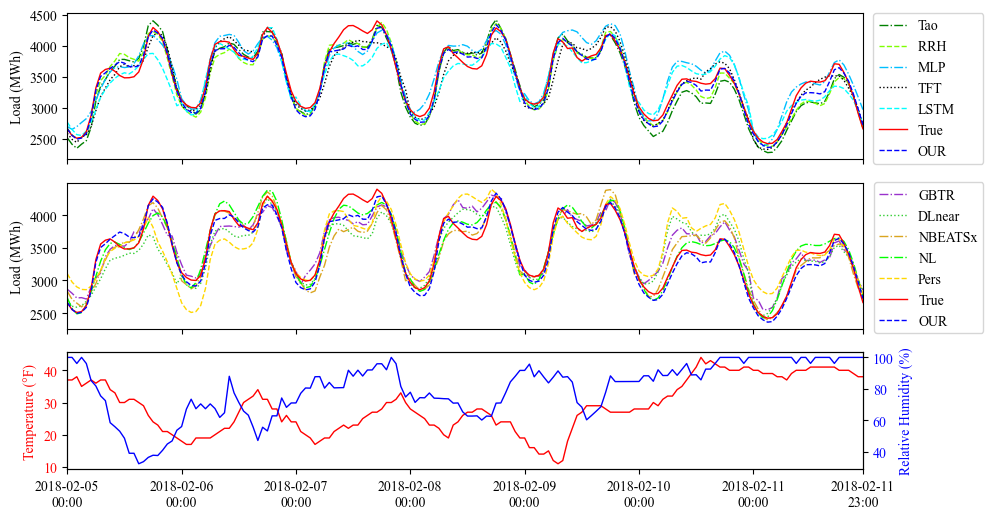

In [17]:
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman')


# k = 49

# k = 17


# k = 5*7

for k in range(1):
    # k *= 7

    k = 5*7

    steplist = [i + k*24 for i in range(168)]

    time_list = hourly_timestamps[steplist]

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(10,5.3), gridspec_kw={'height_ratios': [1.5, 1.5, 1.2]})
    plt.subplots_adjust(hspace=0.03)

    ax1.plot(time_list, np.array(preTao).reshape(-1)[24*k:24*(k+7)], color='Green', linestyle="-.", marker="s", linewidth=1, markersize='0', label="Tao")
    ax1.plot(time_list, np.array(preRRH).reshape(-1)[24*k:24*(k+7)], color='Chartreuse', linestyle="--", marker="s", linewidth=1, markersize='0', label="RRH         ")

    ax1.plot(time_list, np.array(preMLP)[k:k+7].reshape(-1), color='DeepSkyBlue', linestyle="-.", marker="s", linewidth=1, markersize='0', label="MLP")
    ax1.plot(time_list, np.array(preTFT)[k:k+7].reshape(-1), color='Black', linestyle=":", marker="s", linewidth=1, markersize='0', label="TFT")
    ax1.plot(time_list, np.array(preLSTM)[k:k+7].reshape(-1), color='Cyan', linestyle="--", marker="s", linewidth=1, markersize='0', label="LSTM")

    ax1.plot(time_list, y_test[24*k:24*(k+7)], color='red', linestyle="-", marker="s", linewidth=1, markersize='0', label="True")
    ax1.plot(time_list, np.array(pre_our)[24*k:24*(k+7)], color='b', linestyle="--", marker="s", linewidth=1, markersize='0', label="OUR")

    ax1.set_ylabel('Load (MWh)')
    ax1.legend(loc="upper right", bbox_to_anchor=(1.16, 1.048))


    ax2.plot(time_list, np.array(preGBRT)[k:k+7].reshape(-1), color='DarkOrchid', linestyle="-.", marker="s", linewidth=1, markersize='0', label="GBTR")
    ax2.plot(time_list, np.array(preDL)[k:k+7].reshape(-1), color='LimeGreen', linestyle=":", marker="s", linewidth=1, markersize='0', label="DLnear")
    ax2.plot(time_list, np.array(preNB)[k:k+7].reshape(-1), color='GoldEnrod', linestyle="-.", marker="s", linewidth=1, markersize='0', label="NBEATSx")
    ax2.plot(time_list, np.array(preNL)[k:k+7].reshape(-1), color='Lime', linestyle="-.", marker="s", linewidth=1, markersize='0', label="NL")
    ax2.plot(time_list, np.array(prePers)[k:k+7].reshape(-1), color='Gold', linestyle="--", marker="s", linewidth=1, markersize='0', label="Pers")

    ax2.plot(time_list, y_test[24*k:24*(k+7)], color='red', linestyle="-", marker="s", linewidth=1, markersize='0', label="True")
    ax2.plot(time_list, pre_our[24*k:24*(k+7)], color='b', linestyle="--", marker="s", linewidth=1, markersize='0', label="OUR")

    ax2.set_ylabel('Load (MWh)')

    ax2.legend(loc="upper right", bbox_to_anchor=(1.16, 1.048))

    tem_color = 'red'
    rh_color = 'b'

    ax3.plot(time_list, temperature[steplist], color=tem_color, linestyle="-", marker="s", linewidth=1, markersize='0', label="Temperature")

    ax3_right = ax3.twinx()  
    ax3_right.plot(time_list, RH[steplist], color=rh_color, linestyle="-", marker="s", linewidth=1, markersize='0', label="RH")

    # ax2.set_xlabel('Hours in a week')

    ax3.set_ylabel('Temperature (°F)', color=tem_color)
    ax3_right.set_ylabel('Relative Humidity (%)', color=rh_color)

    # ax2.set_ylim((10, 60))
    # ax2_right.set_ylim((30, 110))


    ax3.tick_params(axis='y', labelcolor=tem_color)  # Left y-axis (Temperature)
    ax3_right.tick_params(axis='y', labelcolor=rh_color)  # Right y-axis (RH)

    # ax2.legend(loc="upper right", bbox_to_anchor=(1.16, 1))

    plt.xlim(time_list[0], time_list[-1])
    plt.xticks([time_list[i*24] for i in range(7)]+[time_list[-1]], [(time_list[i*24]).strftime('%Y-%m-%d\n%H:%M') for i in range(7)]+[(time_list[-1]).strftime('%Y-%m-%d\n%H:%M')])
    plt.tight_layout()  

    # plt.savefig(r'load curve/week graph '+ zone_name + '/' + str(k) + 'week ' + zone_name + '_load_curve.png', dpi=600)
    plt.show()

# 2 the model stability of ROEHPE as the number of base learners in the ensemble varies

In [18]:
# Try to read the pickle file.
with open(r"result_record_all/EnsembleGraph.pkl", 'rb') as f:
    our_EnsembleGraph = pickle.load(f)  # Load the file using pickle.

df_results_ens = pd.DataFrame(our_EnsembleGraph)

In [19]:
df_results_ens = pd.DataFrame(our_EnsembleGraph)

df_results_ens_RMSE = df_results_ens.map(lambda x: x.get('ens_test_RMSE', None))
df_results_ens_daily_MAPE = df_results_ens.map(lambda x: x.get('ens_Daily_peak_test_MAPE', None))
df_results_single_RMSE = df_results_ens.map(lambda x: x.get('single_test_RMSE', None))
df_results_single_daily_MAPE = df_results_ens.map(lambda x: x.get('single_Daily_peak_test_MAPE', None))

df_results_ens_RMSE, 
df_results_single_RMSE

,seed_group_0,seed_group_1,seed_group_2,seed_group_3,seed_group_4,seed_group_5,seed_group_6,seed_group_7,seed_group_8,seed_group_9,...,seed_group_41,seed_group_42,seed_group_43,seed_group_44,seed_group_45,seed_group_46,seed_group_47,seed_group_48,seed_group_49,seed_group_50
ensemble time_0,152.478116,169.713080,162.156516,148.224221,150.579504,151.407434,149.521747,146.813061,146.700715,150.215499,...,147.237708,146.722003,153.904323,156.718087,171.714712,149.082766,151.428671,145.426322,145.030633,160.340818
ensemble time_1,148.608560,148.018081,152.227136,159.739767,160.301385,153.465985,148.005920,153.362700,160.309732,148.228276,...,149.561010,153.170261,148.649512,157.291597,150.052316,146.192225,135.873217,148.140428,148.776734,150.791476
ensemble time_2,151.608279,146.013624,148.969339,137.356691,147.365772,137.644876,150.296000,156.849872,145.757428,153.469477,...,148.011179,151.394319,149.308304,148.144373,154.085135,158.970385,146.373844,146.057611,143.888835,149.510346
ensemble time_3,145.908820,147.182636,151.541815,148.198497,154.880158,146.429593,157.457568,147.031999,146.694373,145.775926,...,150.101482,151.403838,151.640438,145.371596,147.817257,145.344767,158.367885,153.951204,152.013473,152.511869
ensemble time_4,151.882100,147.751070,141.503483,152.541739,150.425732,163.320539,152.874868,151.253936,143.423367,153.543385,...,144.825062,151.330286,149.776219,149.444471,151.455303,156.949271,157.091537,143.413279,147.458271,149.316999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ensemble time_95,143.324653,151.054542,156.146169,161.592544,153.154184,145.727432,155.046616,143.515734,149.543197,150.651644,...,151.383253,151.608999,150.468288,145.632683,150.366071,154.042197,147.896716,153.292218,144.391292,153.161419
ensemble time_96,145.445407,148.475448,150.098872,145.163549,151.936032,149.334109,151.925421,149.406459,153.668675,145.853962,...,137.477704,142.975755,149.125033,145.512986,153.701061,154.424389,151.206686,144.670050,146.038069,146.623247
ensemble time_97,153.759483,148.595372,148.419309,161.882766,147.942270,155.883355,153.553862,147.033805,145.595987,169.922570,...,148.935166,148.688692,149.181774,152.402115,152.653410,156.604639,140.711852,157.734345,143.590793,149.846149
ensemble time_98,149.651530,143.677411,149.805645,147.464330,141.746090,145.485148,149.842296,161.599353,145.645059,152.913796,...,145.465943,149.056750,145.266467,152.048099,152.069986,151.665600,156.594255,143.778127,151.071326,154.540001


In [21]:
maxRMSE = df_results_ens_RMSE.max(axis = 1)
minRMSE = df_results_ens_RMSE.min(axis = 1)
meanRMSE = df_results_ens_RMSE.mean(axis = 1)
stdRMSE = df_results_ens_RMSE.std(axis = 1)

RMSE10 = np.percentile(df_results_ens_RMSE, 10, axis = 1)
RMSE90 = np.percentile(df_results_ens_RMSE, 90, axis = 1)

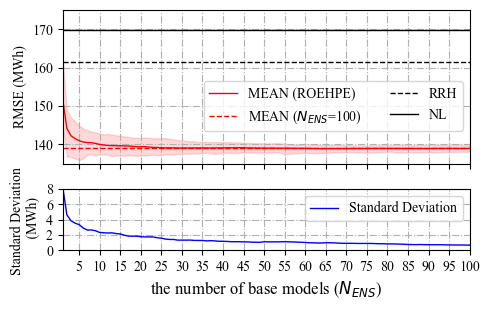

In [22]:
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman')
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.pyplot import MultipleLocator
from matplotlib.lines import Line2D  

cmap = plt.get_cmap('gnuplot2')

norm = mcolors.Normalize(vmin=0, vmax=5)

d = 100

steplist = [int(i+1) for i in range(d)]
NL = [169.81 for i in range(d)]
Recency = [161.42 for i in range(d)]
benchmark = [226.04 for i in range(d)]

linewidth = 1

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(5,3.2), gridspec_kw={'height_ratios': [1.5, 0.6]})
plt.subplots_adjust(hspace=0.1)

# ax = fig.add_subplot(111)

ax.plot(steplist, meanRMSE, color="red", linestyle="-", marker="o", linewidth = linewidth, markerfacecolor='none', markersize='0', label="MEAN (ROEHPE)")

# # 添加上下阴影（标准差）
# ax.fill_between(steplist, [rmse - std for rmse, std in zip(meanRMSE, stdRMSE)],
#                 [rmse + std for rmse, std in zip(meanRMSE, stdRMSE)], color='r', alpha=0.15)

# 添加上下阴影（标准差）
ax.fill_between(steplist, RMSE10,
                RMSE90, color='r', alpha=0.15)


# 画出 x=2 这条垂直线
ax.axhline(138.915457, color="r", linestyle="--", linewidth = linewidth, label="MEAN ($N_{ENS}$=100)")

ax.plot(steplist, Recency, color='Black', linestyle="--", marker="o", linewidth = linewidth, markerfacecolor='none', markersize='0', label="RRH")
ax.plot(steplist, NL, color='Black', linestyle="-", marker="o", linewidth = linewidth, markerfacecolor='none', markersize='0', label="NL")

ax.set_ylabel('RMSE (MWh)',size = 10)

ax.set_xlim(left = 1,right=100)
ax.set_ylim(135, 175)
ax.grid(linestyle='-.')  # 生成网格

# ax.legend(loc="upper left",ncol=3, bbox_to_anchor=(0.01, 1.25))
ax.legend(loc="upper right",ncol=2, bbox_to_anchor=(1, 0.58))

x_major_locator=MultipleLocator(5)

y_major_locator=MultipleLocator(5)

ax=plt.gca()

ax.xaxis.set_major_locator(x_major_locator)

ax.yaxis.set_major_locator(y_major_locator)


legend_elements = [
    Line2D([0], [0], color='grey', lw=4, alpha=0.3, label='Standard Deviation Range')
]


ax.legend(handles=legend_elements, loc='upper left', ncol=1, bbox_to_anchor=(1, 0.25))


# ax2 = ax.twinx()
ax2.plot(steplist, stdRMSE, color='blue', linestyle="-", marker="o", linewidth = linewidth, markerfacecolor='none', markersize='0', label="Standard Deviation")
ax2.set_ylabel('Standard Deviation \n (MWh)',size = 10)

x_major_locator=MultipleLocator(5)

y_major_locator=MultipleLocator(2)

ax=plt.gca()

ax2.xaxis.set_major_locator(x_major_locator)

ax2.yaxis.set_major_locator(y_major_locator)


ax2.set_ylim(0, 8)
ax2.set_xlabel('the number of base models ($N_{ENS}$)',size = 12)
ax2.legend(loc="upper right" )
ax2.grid(linestyle='-.')  

plt.tight_layout()  

plt.savefig('other graph/percentile.png', dpi=600)
plt.show()

# 3 Model performance ranking

In [28]:
# data = { 'zone':['CT', 'ME', 'NEMASS', 'NH', 'RI', 'SEMASS', 'VT', 'WCMASS', 'TOTAL'],
data = { 
    'ROEHPE': [138.99, 63.80, 114.71, 41.68, 30.85, 74.95, 44.54, 81.80, 494.53],
    'GBTR': [217.75, 62.92, 174.80, 71.76, 51.57, 108.01, 46.28, 125.38, 798.41],
    'MLP': [185.49, 53.12, 146.70, 60.72, 44.71, 94.80, 43.60, 108.46, 654.92],
    'TFT': [183.55, 53.24, 138.08, 59.25, 41.89, 97.28, 42.61, 101.70, 625.40],
    'LSTM': [295.52, 69.20, 240.81, 92.27, 78.25, 154.48, 49.30, 141.72, 1003.06],
    'Dlinear': [316.62, 76.58, 255.32, 103.76, 83.74, 156.50, 52.14, 163.38, 1135.90],
    'NBEATSx': [188.62, 53.08, 150.70, 62.18, 46.51, 95.18, 41.92, 106.71, 622.92],
    'NL': [169.81, 54.07, 124.31, 59.70, 40.57, 89.78, 43.68, 95.18, 560.75],
    'RRH': [161.42, 70.52, 131.88, 48.28, 36.28, 84.30, 46.58, 91.64, 566.37],
    'Tao': [226.04, 83.94, 174.52, 73.88, 54.05, 119.02, 54.42, 120.87, 770.78],
    'Pers': [374.52, 89.81, 303.72, 125.87, 98.24, 185.99, 63.47, 199.76, 1360.82]
}

# 创建 DataFrame
df = pd.DataFrame(data)
df.index = ['CT', 'ME', 'NEMASS', 'NH', 'RI', 'SEMASS', 'VT', 'WCMASS', 'TOTAL']

# df.iloc[:,1:] = df.iloc[:, 1:].div(df['Pers'], axis=0)
df = df.div(df['Pers'], axis=0)
df = df.stack().reset_index(drop=False)

df.columns = ['zone', 'method', 'value']

df_sorted = (
    df
    .groupby(["zone"])
    .apply(lambda x: x.sort_values(["value"], ascending = False))
    .reset_index(drop=True)
)

In [29]:
def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment


def add_model_labels(angles, values, labels, offset, ax):
    
    # This is the space between the end of the bar and the label
    padding = 0.01
    
    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):

        angle = angle
        
        if label == "HNL":
            kw={"fontweight":"bold","fontsize":16}
        else:
            kw={"fontsize":14}
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle, 
            y=value + padding, 
            s=label, 
            ha=alignment, 
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor",**kw
        )


def add_number_labels(angles, values, labels, offset, ax):
    
    # This is the space between the end of the bar and the label
    padding = 0.25
    count = 0
    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):
        if (label not in ["Persistence", "HNL"]):
            continue

        angle = angle
        
        if label == "HNL":
            kw={"fontweight":"bold", "fontsize":15}
        else:
            kw={"fontsize":15}
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle, 
            y=value-padding, 
            s="{:.2f}".format(value), 
            ha=alignment, 
            c="white",
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor",**kw
        )
        count+=1


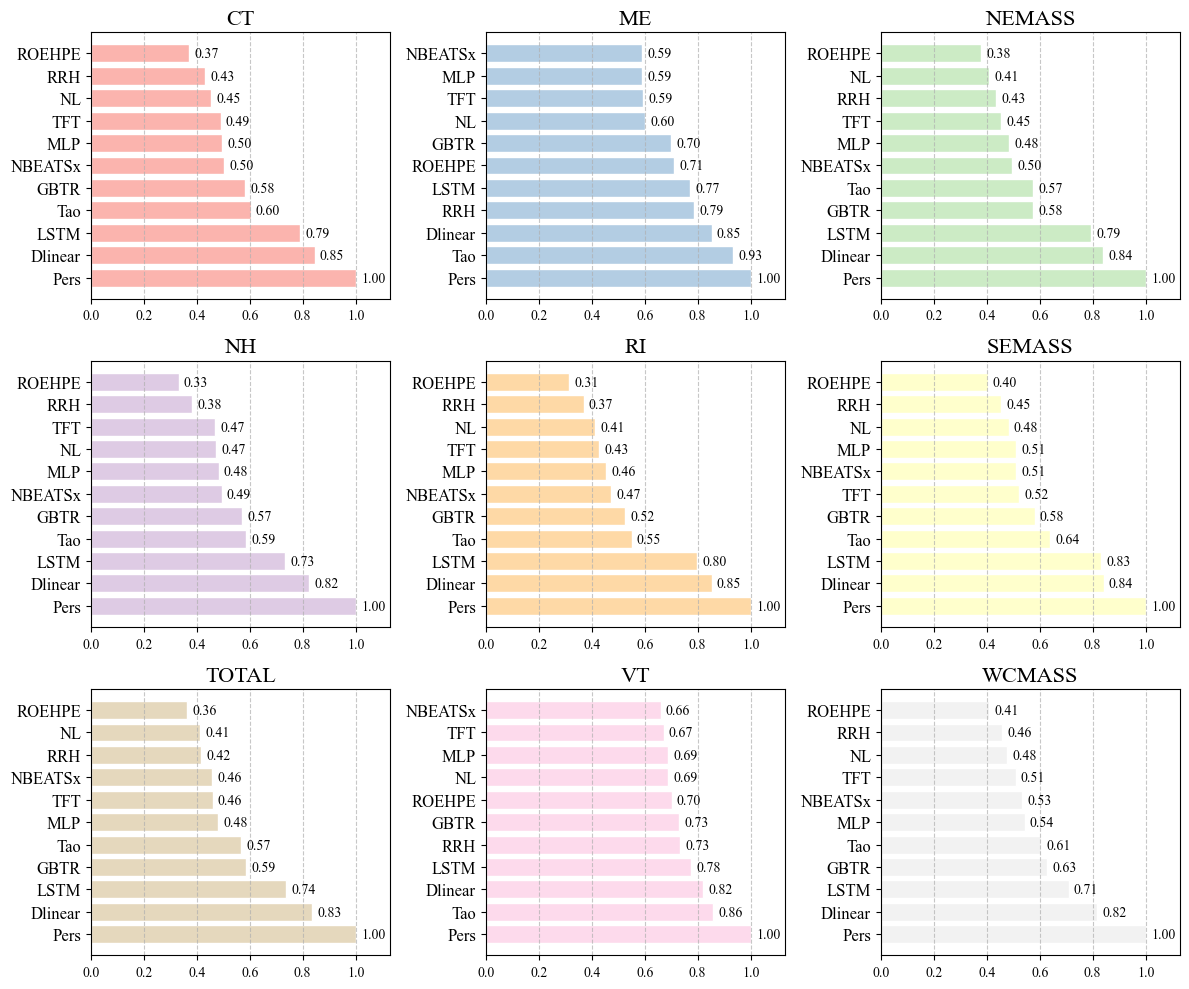

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font',family='Times New Roman')

GROUP = ['CT', 'ME', 'NEMASS', 'NH', 'RI', 'SEMASS', 'VT', 'WCMASS', 'TOTAL']
VALUES = df_sorted["value"].values
LABELS = df_sorted["method"].values

GROUPS_SIZE = [len(i[1]) for i in df_sorted.groupby("zone")]

COLORS = [plt.get_cmap("Pastel1").colors[i] for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

fig, axes = plt.subplots(3, 3, figsize=(12, 10))  


zones = df_sorted["zone"].unique()

for idx, zone in enumerate(zones):
    row = idx // 3  
    col = idx % 3   
    
    ax = axes[row, col] 
    

    zone_data = df_sorted[df_sorted["zone"] == zone]
    zone_values = zone_data["value"].values
    zone_labels = zone_data["method"].values
    
    ax.barh(np.arange(len(zone_values)), zone_values, 
            color=COLORS[idx * len(zone_values):(idx + 1) * len(zone_values)], 
            edgecolor="white", height=0.8)
    
    ax.set_yticks(np.arange(len(zone_values)))
    ax.set_yticklabels(zone_labels, fontsize=12)

    for i, bar in enumerate(ax.patches):
        ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2, 
                f'{bar.get_width():.2f}', va='center', ha='left', fontsize=10, color='black')

    # ax.set_xlabel('Values', fontsize=14)
    ax.set_title(f"{zone}", fontsize=16)
    

    ax.grid(axis='x', linestyle='--', alpha=0.7)

    ax.set_xlim(0, 1.13)

fig.tight_layout()

plt.savefig('other graph/rank.png', dpi=600)
plt.show()




# 4 Using the DEAD-IPB model to evaluate economic benefits

In [68]:
import sys
sys.path.append("..")

import pickle
import numpy as np
import cvxpy as cp
from copy import deepcopy

Cap = 50000
SOC_ini = 0.4
eta_c = 0.95
eta_d = 0.9
N_g = 10
degrade_price = 100
P_battery = Cap/5


Pg_max = np.array([470, 460, 340, 300, 243, 160, 130, 120, 80, 55])
Pg_min = np.array([150, 135, 73, 60, 73, 57, 20, 47, 20, 20])

c = np.array([958.20, 1313.60, 604.97, 471.60, 480.29, 601.75, 502.70, 639.40, 455.60, 692.40])
b = np.array([21.60, 21.05, 20.81, 23.90, 21.62, 17.87, 16.51, 23.23, 19.58, 22.54])
a = np.array([0.00043, 0.00063, 0.00039, 0.00070, 0.00079, 0.00056, 0.00211, 0.00480, 0.10908, 0.00951])

RU = np.array([80, 80, 80, 50, 50, 50, 30, 30, 30, 30])
RD = np.array([80, 80, 80, 50, 50, 50, 30, 30, 30, 30])


def daed(load, delta_t, core_nums = 12, verbose = False):
    N_t = len(load)
    P = cp.Variable((N_g, N_t), name='P')
    SOC = cp.Variable(N_t, name='SOC')
    Pc = cp.Variable(N_t, name='Pc')
    Pd = cp.Variable(N_t, name='Pd')
    phi = cp.Variable(N_t, name='phi', boolean=True)

    P_constraints = [P[:, t] <= Pg_max for t in range(N_t)] + [
        P[:, t] >= Pg_min for t in range(N_t)
    ] + [P[:, t + 1] - P[:, t] <= RU * delta_t for t in range(N_t - 1)
         ] + [P[:, t] - P[:, t + 1] <= RD * delta_t for t in range(N_t - 1)]
    SOC_constraints = [
        Cap * SOC[0] == (Cap * SOC_ini +
                         (Pc[0] * eta_c - Pd[0] / eta_d) * delta_t)
    ] + [
        Cap * SOC[t] == (Cap * SOC[t - 1] +
                         (Pc[t] * eta_c - Pd[t] / eta_d) * delta_t)
        for t in range(1, N_t)
    ] + [
        SOC >= 0.05, SOC <= 0.95, Pc >= 0, Pd >= 0, Pc <= (P_battery * phi), Pd <=
        (P_battery * (1 - phi))
    ]
    balance_constraints = [((sum(P[:, t])) + Pd[t] == (load[t] + Pc[t]))
                           for t in range(N_t)]
    constraints = P_constraints + balance_constraints + SOC_constraints
    # print(constraints)
    objective = cp.Minimize(
        sum((a @ P**2 + b @ P + c.sum())) + 
        sum(((Pc * eta_c * degrade_price  + Pd / eta_d * degrade_price ) )))
    
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver = cp.GUROBI, threads = core_nums, verbose = verbose)
    assert prob.status == "optimal"
    da_opt_P = P.value
    print(sum((a @ da_opt_P**2 + b @ da_opt_P + c.sum())))

    return result, da_opt_P

def ipb(load, da_opt_P, delta_t, core_nums = 12, verbose = False):
    N_t = len(load)

    P = cp.Variable((N_g, N_t), name='P')
    SOC = cp.Variable(N_t, name='SOC')
    Pc = cp.Variable(N_t, name='Pc')
    Pd = cp.Variable(N_t, name='Pd')
    phi = cp.Variable(N_t, name='phi', boolean=True)

    P_constraints = [P == da_opt_P]
    SOC_constraints = [
        Cap * SOC[0] == (Cap * SOC_ini +
                         (Pc[0] * eta_c - Pd[0] / eta_d) * delta_t)
    ] + [
        Cap * SOC[t] == (Cap * SOC[t - 1] +
                         (Pc[t] * eta_c - Pd[t] / eta_d) * delta_t)
        for t in range(1, N_t)
    ] + [
        SOC >= 0.05, SOC <= 0.95, Pc >= 0, Pd >= 0, Pc <=
        (P_battery * phi), Pd <= (P_battery * (1 - phi))
    ]
    balance_constraints = [((sum(P[:, t]) + Pd[t]) == (load[t] + Pc[t]))
                           for t in range(N_t)]
    constraints = P_constraints + SOC_constraints + balance_constraints
    # print(constraints)
    objective = cp.Minimize(
        sum((a @ P**2 + b @ P + c.sum())) + 
        sum(((Pc * eta_c * degrade_price  + Pd / eta_d * degrade_price ) )))
    
    prob = cp.Problem(objective, constraints)

    result = prob.solve(solver=cp.GUROBI, threads=core_nums, verbose = verbose)
    assert prob.status == "optimal"


    return result, (P.value, SOC.value, Pc.value, Pd.value)


In [ ]:
# DAED
import time
import os
from joblib import Parallel, delayed


def cost_eval(pre_load, true_load, ideal_cost, delta_t = 1):

    # DAED
    # print("daed schedule")
    daed_cost, daed_P = daed(load = pre_load, delta_t=delta_t)

    # IPB
    ipb_cost, ipb_out = ipb(load = true_load,
                            da_opt_P=daed_P,
                            delta_t=delta_t)

    print("cost diff:")
    diffs = ipb_cost - ideal_cost
    print(diffs)

    return diffs, ipb_cost, ipb_out

# cost_zone_dict= {}
delta_t = 1
k = 24 

for zone_name in ['RI']:

    preMLP, preTFT, preLSTM, pre_our, preGBRT, preDL, preNB, preNL = [], [], [], [], [], [], [], []
    zone = 'zone_' + zone_name

    for i in range(10):
        # Try to read the pickle file.
        with open(f"result_record_all/day/other model/oneday_benckmark_{i}.pkl", 'rb') as f:
            predict_benchmark = pickle.load(f)  # Load the file using pickle.

        # Try to read the pickle file.
        with open(f"result_record_all/day/GBTR/oneday_GBTR_{i}.pkl", 'rb') as f:
            predict_GBRT = pickle.load(f)  # Load the file using pickle.

        # Try to read the pickle file.
        with open(f"result_record_all/ROEHPE/our_recode{i}.pkl", 'rb') as f:
            predict_our = pickle.load(f)  # Load the file using pickle.

        # Try to read the pickle file.
        with open(f"result_record_all/Tao and RRH/Tao and RRH result.pkl", 'rb') as f:
            predict_RRHTao = pickle.load(f)  # Load the file using pickle.

        print("The file has been successfully loaded.")


        label_std = (predict_benchmark[zone]['train_std'][0]).numpy()
        label_mean = (predict_benchmark[zone]['train_mean'][0]).numpy()

        preNL.append( (predict_benchmark[zone]['Neural Laplace']['test_preds']) * label_std + label_mean )
        preLSTM.append( (predict_benchmark[zone]['LSTM']['test_preds']) * label_std + label_mean )
        preMLP.append( (predict_benchmark[zone]['MLP']['test_preds']) * label_std + label_mean )
        preDL.append( (predict_benchmark[zone]['DLinear']['test_preds']) * label_std + label_mean )
        preNB.append( (predict_benchmark[zone]['NBEATSx']['test_preds']) * label_std + label_mean )
        preTFT.append( (predict_benchmark[zone]['TFT']['test_preds']) * label_std + label_mean )

        preGBRT.append( (predict_GBRT[zone]['GBRT']['test_preds']) * label_std + label_mean )
        pre_our.append( predict_our[zone]['pre_test_load'] )

        if i == 0:
            prePers = [ (predict_benchmark[zone]['Persistence']['test_preds']) * label_std + label_mean ]
            preTao = [predict_RRHTao[zone_name]['Tao']['test_preds']]
            preRRH = [predict_RRHTao[zone_name]['RRH']['test_preds']]
            
    print("The file has been successfully loaded.")

    np.array(pre_our).shape, np.array(preGBRT).shape


    model_name_list = ['Neural Laplace', 'LSTM', 'MLP', 'DLinear', 'NBEATSx', 'TFT', 'Persistence', 'GBTR', 'Tao', 'RRH', 'ROEHPE']

    model_pre_list = [preNL, preLSTM, preMLP, preDL, preNB, preTFT, prePers, preGBRT, preTao, preRRH, pre_our]

    start_year = 2015
    _, _, _, _, X_test, y_test = get_zone_train(
        df, df2, zone=zone_name,
        train_start = pd.Timestamp(start_year, 1, 1),
        train_end = pd.Timestamp(start_year + 2, 1, 1),
        valid_start = pd.Timestamp(start_year + 2, 1, 1),
        valid_end = pd.Timestamp(start_year + 3, 1, 1),
        test_start = pd.Timestamp(start_year + 3, 1, 1),
        test_end = pd.Timestamp(start_year + 4, 1, 1),
        log=False, num_hour = 0, num_day = 0, RH = True
    )

    temperature = X_test[:, 1]
    RH = X_test[:, 2]
    temperature, RH, y_test

    cost_dict = {}
    ipb_samples_dict = {}

    step = 365

    max_cores = os.cpu_count()
    print('max cores', max_cores)

    ideal_cost_list = []
    results = Parallel(n_jobs=max_cores-1)(delayed(daed)(load = y_test.reshape(-1)[s * 24: s * 24 + k ], delta_t=delta_t) for s in range(step))
    for [ideal_cost, ideal_P] in (results):
        # ipb_samples.append(ipb_out)
        ideal_cost_list.append(ideal_cost)

    for i in range(len(model_name_list)):
    # for i in range(1):

        pre_load_list = model_pre_list[i]
        opt_cost = []
        ipb_samples = []
        
        for pre_load in pre_load_list:
        # for pre_load in [pre_load_list[0]]:

            ipb_samples_single, opt_cost_single = [], []
            results = Parallel(n_jobs=max_cores-1)(delayed(cost_eval)(
                pre_load = pre_load.reshape(-1)[s * 24: s * 24 + k ], true_load = y_test.reshape(-1)[s * 24: s * 24 + k ], ideal_cost = ideal_cost_list[s]) for s in range(step))

            for [diffs, ipb_cost, ipb_out] in (results):
                ipb_samples_single.append(ipb_out)
                opt_cost_single.append(diffs)
                

            opt_cost.append( np.array(opt_cost_single).mean()/24 )
            ipb_samples.append( ipb_samples_single )

        cost_dict[model_name_list[i]] = [np.array(opt_cost).mean(), np.array(opt_cost).std()]

        ipb_samples_dict[model_name_list[i]] = ipb_samples
        print('one experiment finish')

cost_zone_dict[zone_name] = cost_dict


The file has been successfully loaded.
The file has been successfully loaded.
The file has been successfully loaded.
The file has been successfully loaded.
The file has been successfully loaded.
The file has been successfully loaded.
The file has been successfully loaded.
The file has been successfully loaded.
The file has been successfully loaded.
The file has been successfully loaded.
The file has been successfully loaded.
max cores 16
one experiment finish
one experiment finish
one experiment finish
one experiment finish
one experiment finish
one experiment finish
one experiment finish
one experiment finish
one experiment finish
one experiment finish
one experiment finish


In [74]:
model_name = []
mean_list = []
std_list = []

for zone in cost_zone_dict.keys():
    for model in cost_zone_dict[zone].keys():
        model_name.append(model)
        mean_list.append(cost_zone_dict[zone][model][0])
        std_list.append(cost_zone_dict[zone][model][1])

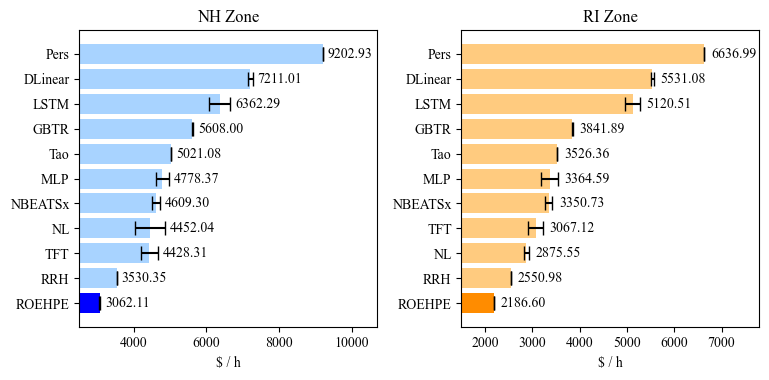

In [ ]:

models = ['NL', 'LSTM', 'MLP', 'DLinear', 'NBEATSx', 'TFT', 'Pers', 
          'GBTR', 'Tao', 'RRH', 'ROEHPE']

errors_1 = np.array(std_list).reshape(2,-1)[0]
errors_2 = np.array(std_list).reshape(2,-1)[1]

values_1 = np.array(mean_list).reshape(2,-1)[0]
values_2 = np.array(mean_list).reshape(2,-1)[1]

sorted_indices_1 = np.argsort(values_1)
sorted_indices_2 = np.argsort(values_2)

models_sorted_1 = np.array(models)[sorted_indices_1]
values_sorted_1 = np.array(values_1)[sorted_indices_1]

models_sorted_2 = np.array(models)[sorted_indices_2]
values_sorted_2 = np.array(values_2)[sorted_indices_2]

errors_sorted_1 = errors_1[sorted_indices_1]
errors_sorted_2 = errors_2[sorted_indices_2]

colors_1 = ['blue' if model == 'ROEHPE' else (0.6, 0.8, 1, 0.85) for model in models_sorted_1]
colors_2 = ['darkorange' if model == 'ROEHPE' else (1, 0.6, 0, 0.5) for model in models_sorted_2]

fig, ax = plt.subplots(1, 2, figsize=(7.8, 3.9))

bars_1 = ax[0].barh(models_sorted_1, values_sorted_1, color=colors_1, xerr=errors_sorted_1, capsize=5)
ax[0].set_title('NH Zone')
ax[0].set_xlabel('$ / h')

for i, (v, err) in enumerate(zip(values_sorted_1, errors_sorted_1)):
    ax[0].text(v + err + 140, i, f'{v:.2f}', va='center', ha='left', color='black')

bars_2 = ax[1].barh(models_sorted_2, values_sorted_2, color=colors_2, xerr=errors_sorted_2, capsize=5)
ax[1].set_title('RI Zone')
ax[1].set_xlabel('$ / h')

for i, (v, err) in enumerate(zip(values_sorted_2, errors_sorted_2)):
    ax[1].text(v + err + 140, i, f'{v:.2f}', va='center', ha='left', color='black')

ax[0].set_xlim([2500, 10700])
ax[1].set_xlim([1500, 7800])

plt.tight_layout()
# plt.savefig('cost.png', dpi=600)
plt.show()